## 1. 환경설정
--------------------------------------

In [50]:
#============================================================
# ▶ 모듈 불러오기
#============================================================
# 시스템
import sys
import os
import re
import time

# EDA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats  

# 기타
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [51]:
#============================================================
# ▶ 설정
#============================================================
# 한글폰트 설정 1
# plt.rcParams['font.family'] = 'Noto Sans KR'

# 한글폰트 설정 2
# plt.rcParams['font.family'] = 'Malgun'

# 한글폰트 설정 2
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='./resources/fonts/NotoSansKR-Regular.otf').get_name()
rc('font',family=font_name)


In [52]:
#============================================================
# ▶ 함수기능 설정
#============================================================

# 1. 컬럼타입 확인
def show_col_type(df) :
    numerical_columns = df.select_dtypes(exclude='object').columns
    categorical_columns = df.select_dtypes(include='object').columns

    print('▶컬럼타입')
    print('-'*100)
    print(f'수치형: {numerical_columns}\n')
    print(f'범주형: {categorical_columns}')
    print()

# 2. 결측치 확인
def show_missing_values(df) :
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    print('▶결측치')
    print('-'*100)
    display(missing_values)
    print()
    


# 2. 데이터 분석 
------------------------------

### 2-1. 데이터 확인

In [53]:
#============================================================
# ▶ 데이터 불러오기
#============================================================
df = pd.read_csv('./data/Korean_demographics.csv')
display(df.head(4))

,Date,Region,Birth,Birth_rate,Death,Death_rate,Divorce,Divorce_rate,Marriage,Marriage_rate,Natural_growth,Natural_growth_rate
0,1/1/2000,Busan,3752.0,11.61,1875.0,5.8,814.0,2.5,2435.0,7.5,1877.0,5.8
1,1/1/2000,Chungcheongbuk-do,1903.0,15.06,924.0,7.3,220.0,1.7,828.0,6.6,979.0,7.7
2,1/1/2000,Chungcheongnam-do,2398.0,14.75,1466.0,9.0,321.0,2.0,1055.0,6.5,932.0,5.7
3,1/1/2000,Daegu,3057.0,14.39,1117.0,5.3,422.0,2.0,1577.0,7.4,1940.0,9.1


In [54]:
#============================================================
# ▶ 데이터 확인 1
#============================================================

# 1. 데이터 정보 확인
print('▶데이터 정보')
print('-'*100)
print(df.info())
print()

# 2. 데이터 사이즈 확인
print('▶데이터 사이즈 (행/렬)')
print('-'*100)
print(df.shape)
print()



▶데이터 정보
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 4860 non-null   object 
 1   Region               4860 non-null   object 
 2   Birth                4716 non-null   float64
 3   Birth_rate           4709 non-null   float64
 4   Death                4716 non-null   float64
 5   Death_rate           4709 non-null   float64
 6   Divorce              4716 non-null   float64
 7   Divorce_rate         4709 non-null   float64
 8   Marriage             4716 non-null   float64
 9   Marriage_rate        4709 non-null   float64
 10  Natural_growth       4716 non-null   float64
 11  Natural_growth_rate  4709 non-null   float64
dtypes: float64(10), object(2)
memory usage: 455.8+ KB
None

▶데이터 사이즈 (행/렬)
--------

In [55]:
# ->Date컬럼을 날짜 형식으로 변환할 필요가 있음

In [56]:
#============================================================
# ▶ 데이터 확인 2
#============================================================

# 3. 컬럼타입 확인
show_col_type(df)

# 4. 결측치 확인
show_missing_values(df)

▶컬럼타입
----------------------------------------------------------------------------------------------------
수치형: Index(['Birth', 'Birth_rate', 'Death', 'Death_rate', 'Divorce', 'Divorce_rate',
       'Marriage', 'Marriage_rate', 'Natural_growth', 'Natural_growth_rate'],
      dtype='object')

범주형: Index(['Date', 'Region'], dtype='object')

▶결측치
----------------------------------------------------------------------------------------------------


Birth                  144
Birth_rate             151
Death                  144
Death_rate             151
Divorce                144
Divorce_rate           151
Marriage               144
Marriage_rate          151
Natural_growth         144
Natural_growth_rate    151
dtype: int64

In [57]:
# -> Date와 Region을 제외한 10개 데이터에 결측치처리가 필요함

#### 확인결과 :

1) Date컬럼 형식을 날짜 타입으로 변환
2) Date와 Region을 제외한 10개 데이터에 결측치처리가 필요함
3) 이상치 데이터의 처리가 필요함

### 2-2.기본 데이터 전처리 (1차) 
- 날짜타입변환
- 결측치 처리
- 이상치 처리

In [58]:
#============================================================
# ▶ Date 파생변수 생성(Year,Month,Day)
#============================================================

# 1) Date컬럼 형식을 날짜 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head(2)

# 2) Year, Month, Day 컬럼 추가
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# 3) Date 컬럼 삭제
df = df.drop(columns=['Date'],errors='ignore')
print('변환작업 완료')

변환작업 완료


In [59]:
#============================================================
# ▶ 결측치 처리 
#============================================================

# 1. 지역별 평균값 대체 : Birth_rate, Death_rate, Divorce_rate, Marriage_rate,Natural_growth_rate
col2fill = ["Birth_rate", "Death_rate", "Divorce_rate", "Marriage_rate", "Natural_growth_rate"]
for column in col2fill:
    df[column] = df.groupby("Region")[column].transform(lambda x: x.fillna(x.mean()))


# 2. 컬럼 제거 : Birth, Death, Divorce, Marriage, Natural_growth (결측치 144개) 
#    설명 : 결측치 수가 전체 데이터의 약 5% 미만으로 비교적 적은 수치기 때문에 해당 행의 데이터를 제거
del_col = ['Birth', 'Death', 'Divorce', 'Marriage', 'Natural_growth']
df.dropna(subset=del_col, inplace=True)

# 3. 결측치 확인
show_missing_values(df)

▶결측치
----------------------------------------------------------------------------------------------------


Series([], dtype: int64)

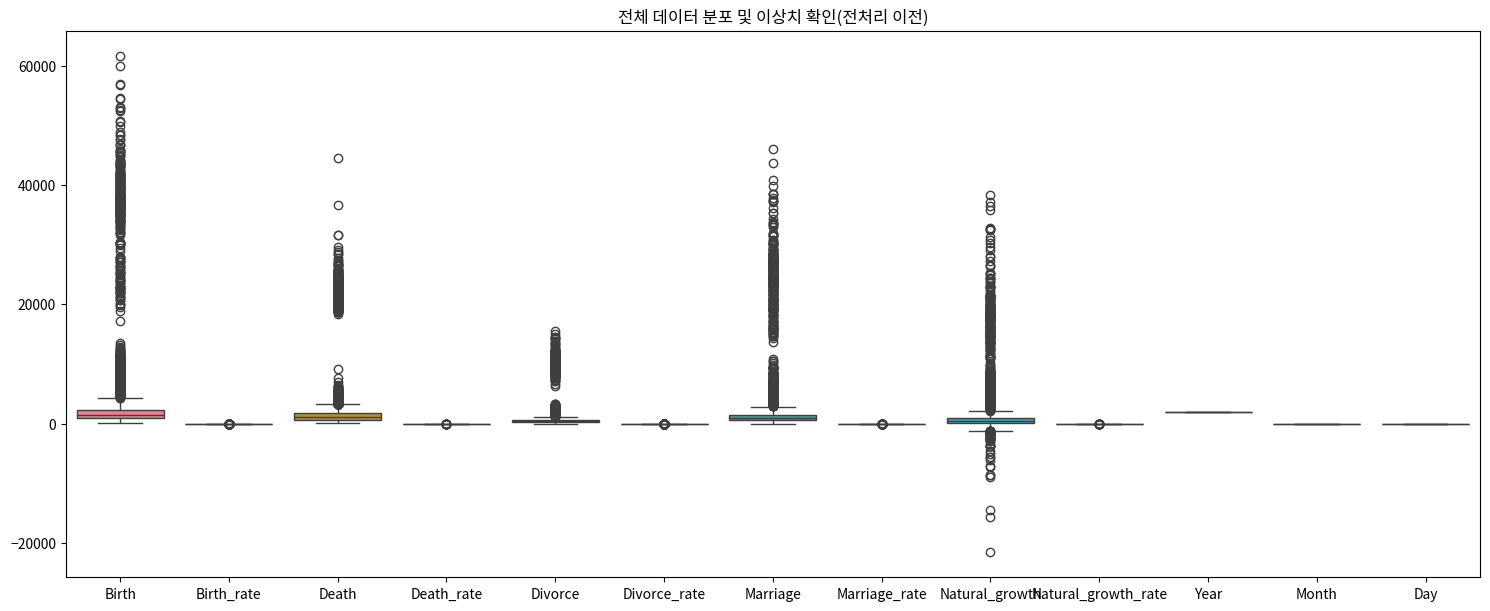

In [60]:
#============================================================
# ▶이상치 수치확인 (전처리전)
#============================================================
plt.figure(figsize=(15,6))
sns.boxplot(data=df)
plt.tight_layout()
plt.title('전체 데이터 분포 및 이상치 확인(전처리 이전)')
plt.show()    

In [61]:
#============================================================
# ▶ 이상치(outlier) 처리 준비

    # 평균에서 표준편차 3배 이상 벗어난 값 필터링하여 이상치 처리
#============================================================
# 1. 타입별로 컬럼분류 
numeric_col = df[[
    'Birth', 
    'Death', 
    'Divorce',
    'Marriage', 
    'Natural_growth'
]]
numeric_rate_col = df[[
    'Birth_rate', 
    'Death_rate', 
    'Divorce_rate', 
    'Marriage_rate',
    'Natural_growth_rate'
]]

# 2. 이상치 체크할 컬럼 선정
outlier_check_columns = df.drop(columns=["Year", "Month", "Day", "Region"], errors="ignore").columns
outlier_check_df = df.drop(columns=["Year", "Month", "Day", "Region"], errors="ignore")
outlier_check_df

,Birth,Birth_rate,Death,Death_rate,Divorce,Divorce_rate,Marriage,Marriage_rate,Natural_growth,Natural_growth_rate
0,3752.0,11.61,1875.0,5.8,814.0,2.5,2435.0,7.5,1877.0,5.8
1,1903.0,15.06,924.0,7.3,220.0,1.7,828.0,6.6,979.0,7.7
2,2398.0,14.75,1466.0,9.0,321.0,2.0,1055.0,6.5,932.0,5.7
3,3057.0,14.39,1117.0,5.3,422.0,2.0,1577.0,7.4,1940.0,9.1
4,1859.0,16.08,565.0,4.9,280.0,2.4,868.0,7.5,1294.0,11.2
...,...,...,...,...,...,...,...,...,...,...
4855,565.0,3.80,1369.0,9.1,299.0,2.0,479.0,3.2,-805.0,-5.4
4856,248.0,7.90,106.0,3.4,43.0,1.4,123.0,3.9,141.0,4.5
4857,3137.0,4.10,3631.0,4.7,1088.0,1.4,2630.0,3.4,-494.0,-0.6
4858,443.0,4.80,434.0,4.7,154.0,1.7,316.0,3.5,9.0,0.1


In [62]:
# #============================================================
# # ▶ 이상치(outlier) Zscore 처리  : 방법1 
# #============================================================
# for col in outlier_check_columns:
#     # Z-score 계산
#     z_scores = (df[col] - df[col].mean()) / df[col].std()
    
#     # 평균 ±3σ 밖의 이상치 마스크 생성 (|Z-score| > 3)
#     outlier_mask = abs(z_scores) > 3
    
#     # 이상치를 중앙값으로 대체
#     median = df[col].median()
#     df[col] = np.where(outlier_mask, median, df[col])


In [63]:
#============================================================
# ▶ 이상치(outlier) IQR 처리 : 방법2 / 비대칭 데이터 로그변환
#============================================================
# for col in outlier_check_columns:
#     # IQR사용
#     Q1 = df[col].quantile(0.25)  
#     Q3 = df[col].quantile(0.75)  
#     IQR = Q3 - Q1  
#     lower_bound = Q1 - 1.5 * IQR  
#     upper_bound = Q3 + 1.5 * IQR  
    
#     # 필터링
#     outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    
#     # 중앙값대체
#     median = df[col].median()
#     df[col] = df[col].mask(outlier_mask, median)

for col in outlier_check_columns:
    # 로그 변환 (값이 0 이상인 컬럼에만 적용)
    if (df[col] > 0).all():
        log_data = np.log(df[col])
        Q1_log = log_data.quantile(0.25)
        Q3_log = log_data.quantile(0.75)
        IQR_log = Q3_log - Q1_log
        lower_bound_log = Q1_log - 1.5 * IQR_log
        upper_bound_log = Q3_log + 1.5 * IQR_log
        outlier_mask = (log_data < lower_bound_log) | (log_data > upper_bound_log)
    else:
        # 기존 IQR 방법 적용
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    # 중앙값 대체
    median = df[col].median()
    df[col] = df[col].mask(outlier_mask, median)


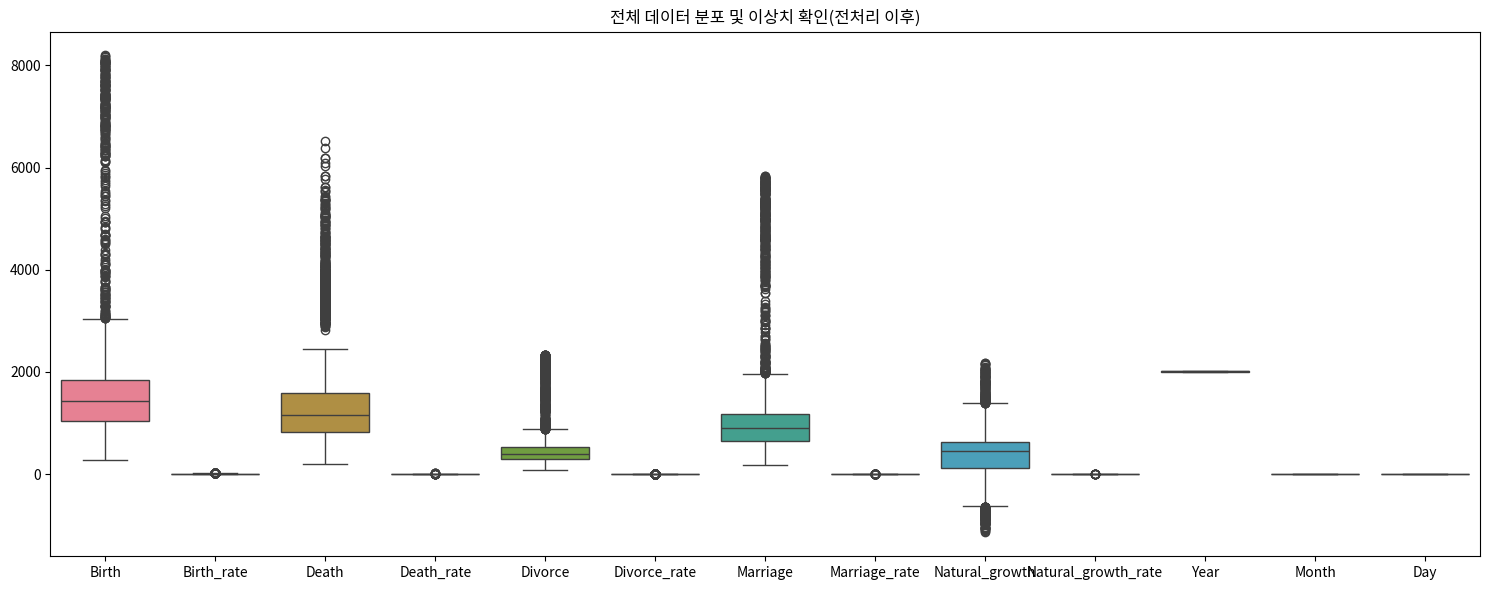

In [64]:
#============================================================
# ▶이상치 수치확인 (전처리 이후)
#============================================================
plt.figure(figsize=(15,6))
sns.boxplot(data=df)
plt.title('전체 데이터 분포 및 이상치 확인(전처리 이후)')
plt.tight_layout()
plt.show()    

### 2-3. 가설검증

저출산 문제:

- 가설 1: 결혼율 감소가 출생률 하락의 주요 원인일것이다.

- 가설 2 : 지역별 경제 수준과 출산율의 상관관계가 높을것이다.(추가데이터수집필요)(지역별 경제소득 데이터)

- 가설 3: 수도권의 높은 생활비가 출산 기피로 이어진다.(추가데이터수집필요)(수도권 물가지수 데이터)
  
- 가설 4 : 20~30대의 높은 실업률이 결혼율 감소에  주요 원인일것이다.(추가데이터수집필요/2030실업률 데이터)

지방 공동화:

- 가설 1: 지방의 낮은 혼인율이 인구 감소를 가속화할것이다.

- 가설 2 : 지방의 고령화 지수(사망률 대비 출생률)가 수도권보다 높을것이다.(추가데이터수집필요/2030실업률 데이터)

- 가설 3: 지방의 청년 인구 유출이 자연증가율 마이너스로 연결될것이다.(추가데이터수집필요/전국 인구수 및 인구이동 데이터)

- 가설 4: 수도권으로의 인구 유입이 지방 인구 감소를 가속화할것이다.(추가데이터수집필요/전국 인구수 및 인구이동 데이터)

#### 저출산 문제:

가설 1: 결혼율 감소가 출생률 하락의 주요 원인일것이다.

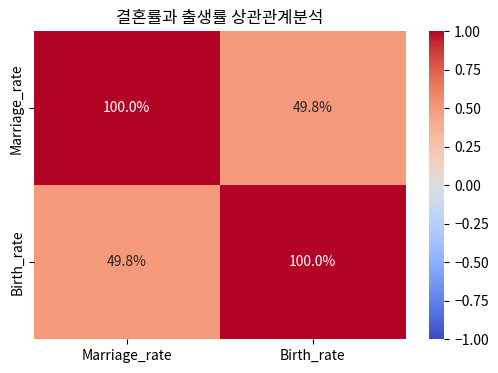

In [65]:
# 상관계수 행렬 계산
correlation_matrix = df[['Marriage_rate', 'Birth_rate']].corr('spearman')

# 히트맵
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',vmin=-1, vmax=1, fmt='.1%')
plt.title('결혼률과 출생률 상관관계분석')
plt.show()

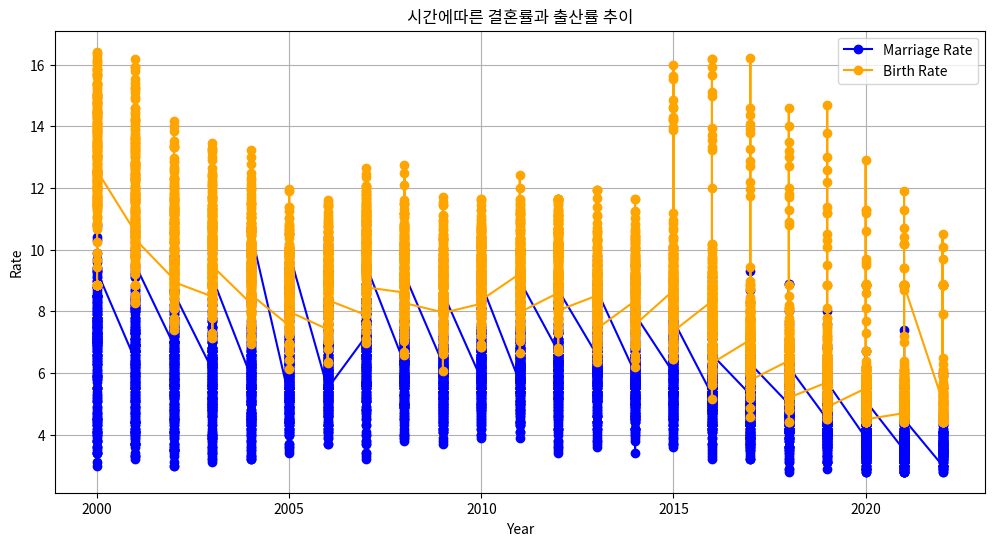

In [66]:
# 선 그래프
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Marriage_rate'], marker='o', label='Marriage Rate', color='blue')
plt.plot(df['Year'], df['Birth_rate'], marker='o', label='Birth Rate', color='orange')
plt.title('시간에따른 결혼률과 출산률 추이')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()


#### 지방공동화
가설 1: 지방의 낮은 혼인율이 인구 감소를 가속화할것이다.

In [67]:
#=====================================================================
# ▶지방공동화 가설1
# ▶검증내용 : 지방의 낮은 혼인율이 인구감소를 가속화한다. / 
#=====================================================================
capital_regions = ["Seoul", "Incheon", "Gyeonggi-do"]

df["Is_Capital"] = df["Region"].isin(capital_regions)

capital_df     = df[df["Is_Capital"] == True]
non_capital_df = df[df["Is_Capital"] == False]


<Axes: xlabel='Year', ylabel='Marriage_rate'>

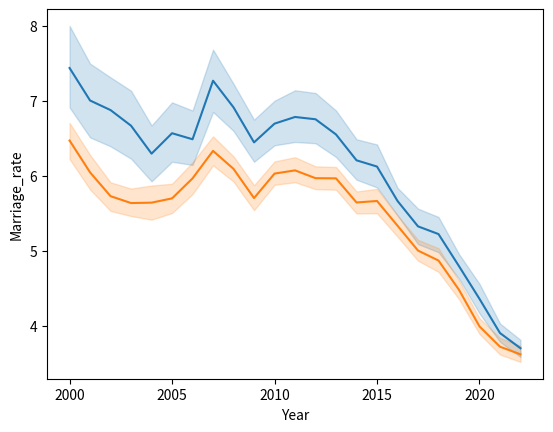

In [79]:
sns.lineplot(data=capital_df,x='Year',y='Marriage_rate')
sns.lineplot(data=non_capital_df,x='Year',y='Marriage_rate')


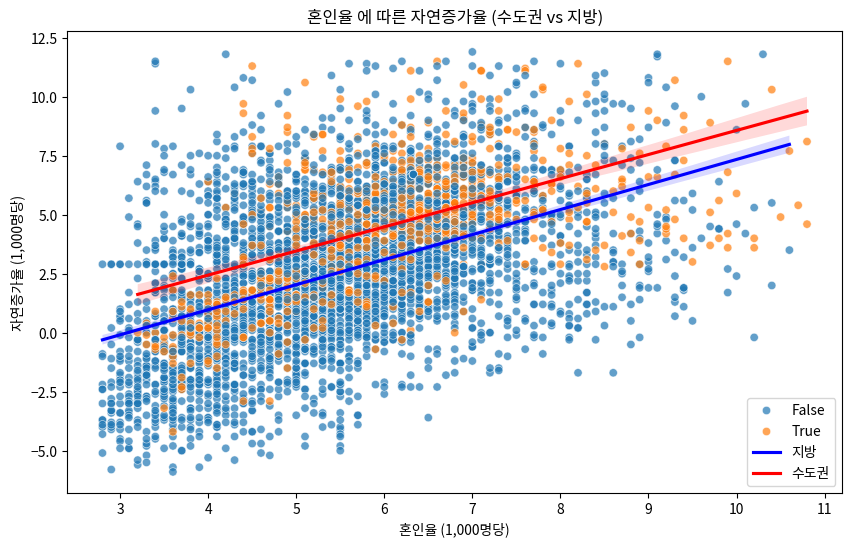

In [69]:
#=====================================================================
# ▶ 수도권 vs 지방 비교 (1) :  산점도 + 회귀선
#=====================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Marriage_rate",
    y="Natural_growth_rate",
    # y="Birth_rate",
    hue="Is_Capital",
    data=df,
    alpha=0.7
)

# 회귀선 추가
sns.regplot(
    x=non_capital_df["Marriage_rate"],
    y=non_capital_df["Natural_growth_rate"],
    # y=non_capital_df["Birth_rate"],
    scatter=False,
    color="blue",
    label="지방"
)
sns.regplot(
    x=capital_df["Marriage_rate"],
    y=capital_df["Natural_growth_rate"],
    # y=capital_df["Birth_rate"],
    scatter=False,
    color="red",
    label="수도권"
)

plt.title("혼인율 에 따른 자연증가율 (수도권 vs 지방)")
plt.xlabel("혼인율 (1,000명당)")
plt.ylabel("자연증가율 (1,000명당)")
plt.legend()
plt.show()

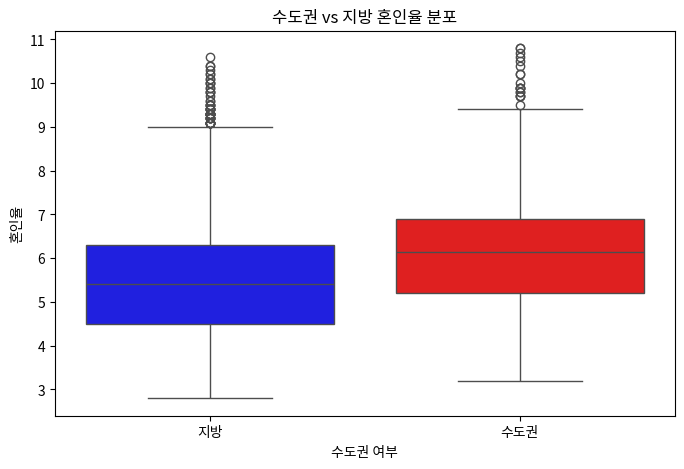

In [70]:

#=====================================================================
# ▶ 지역별 혼인율 분포 : boxplot
#=====================================================================
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Is_Capital",
    y="Marriage_rate",
    data=df,
    palette={"True": "red", "False": "blue"}
)
plt.title("수도권 vs 지방 혼인율 분포")
plt.xlabel("수도권 여부")
plt.ylabel("혼인율")
plt.xticks([0, 1], ["지방", "수도권"])
plt.show()

In [71]:
# 지방 데이터 상관계수
corr_non_capital, pval_non_capital = stats.pearsonr(
    non_capital_df["Marriage_rate"],
    non_capital_df["Natural_growth_rate"]
)

# 수도권 데이터 상관계수
corr_capital, pval_capital = stats.pearsonr(
    capital_df["Marriage_rate"],
    capital_df["Natural_growth_rate"]
)

print(f"[지방] 혼인율-자연증가율 상관계수: {corr_non_capital:.2f} (p-value: {pval_non_capital:.4f})")
print(f"[수도권] 혼인율-자연증가율 상관계수: {corr_capital:.2f} (p-value: {pval_capital:.4f})")


[지방] 혼인율-자연증가율 상관계수: 0.47 (p-value: 0.0000)
[수도권] 혼인율-자연증가율 상관계수: 0.55 (p-value: 0.0000)


In [72]:
# 가설1 :지방의 낮은 혼인율이 인구 감소를 가속화한다.
    # 검증 :=> 지방의 혼인률이 수도권보다 적다고 해서 인구가 감소하지는 않는다.
    # 지방의 혼인률이 수도권보다는 낮기는 하지만 자연증가율을 볼때 크게 차이가 느껴지지않는다.

In [73]:
# 추가고려 : 대도시와 소도시사이에는 혼인률에 따라 인구감소가 일어날까?


# 1. 큰 도시 목록 정의
big_cities = ["Seoul", "Incheon", "Gyeonggi-do", "Daejeon", "Gwangju", "Daegu", "Ulsan", "Busan"]

# 2. 'Is_bigcity' 컬럼 추가
df["Is_bigcity"] = df["Region"].isin(big_cities)



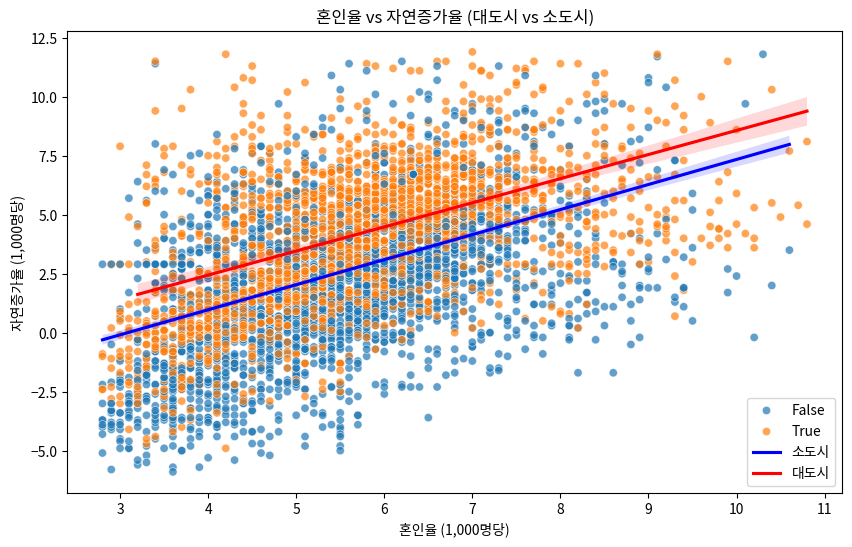

In [74]:
#=====================================================================
# ▶ 대도시 vs 소도시 비교 (1) :  산점도 + 회귀선
#=====================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Marriage_rate",
    y="Natural_growth_rate",
    hue="Is_bigcity",
    data=df,
    alpha=0.7
)

# 회귀선 추가
sns.regplot(
    x=non_capital_df["Marriage_rate"],
    y=non_capital_df["Natural_growth_rate"],
    scatter=False,
    color="blue",
    label="소도시"
)
sns.regplot(
    x=capital_df["Marriage_rate"],
    y=capital_df["Natural_growth_rate"],
    scatter=False,
    color="red",
    label="대도시"
)

plt.title("혼인율 vs 자연증가율 (대도시 vs 소도시)")
plt.xlabel("혼인율 (1,000명당)")
plt.ylabel("자연증가율 (1,000명당)")
plt.legend()
plt.show()

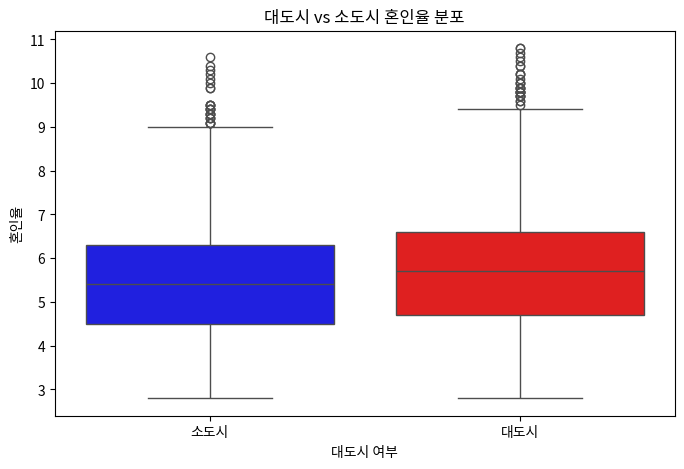

In [75]:
#=====================================================================
# ▶ 대도시 vs 소도시  혼인율 분포 : boxplot
#=====================================================================
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Is_bigcity",
    y="Marriage_rate",
    data=df,
    palette={"True": "red", "False": "blue"}
)
plt.title("대도시 vs 소도시 혼인율 분포")
plt.xlabel("대도시 여부")
plt.ylabel("혼인율")
plt.xticks([0, 1], ["소도시", "대도시"])
plt.show()

In [76]:
# 대도시와 소도시 역시 큰 차이가 없으므로 
# 소도시의 혼인률이 대도시에 비해 적긴 하나, 현격히 적은것이 아니고, 자연발생률증가에 차이도 크게 보이지 않는다.

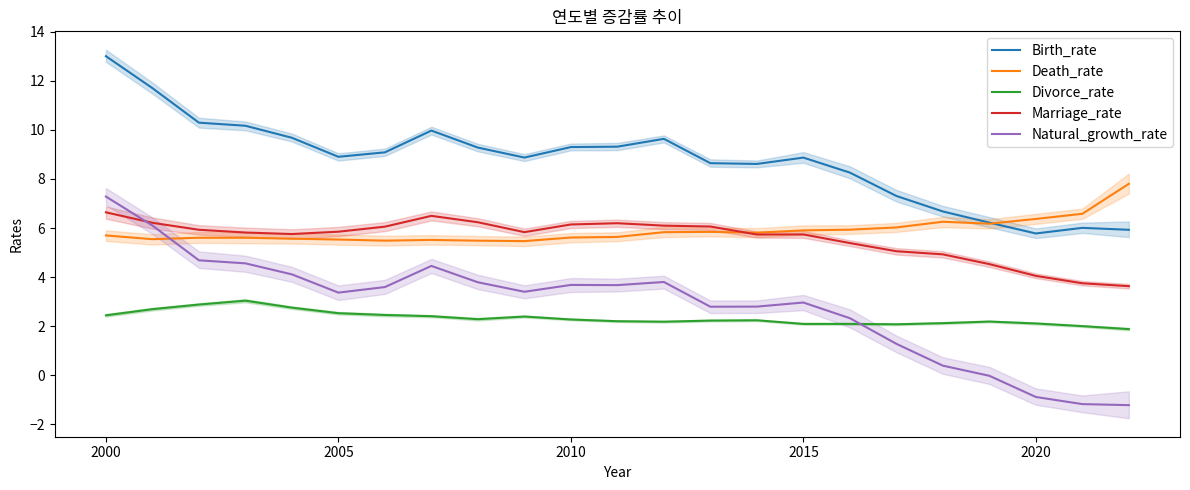

In [77]:
# numeric_rate_col에 대해 lineplot 그리기
plt.figure(figsize=(12,5))
for col in numeric_rate_col:
    sns.lineplot(data=df, x='Year', y=col,  label=col,)

plt.title('연도별 증감률 추이')
plt.xlabel('Year')
plt.ylabel('Rates')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

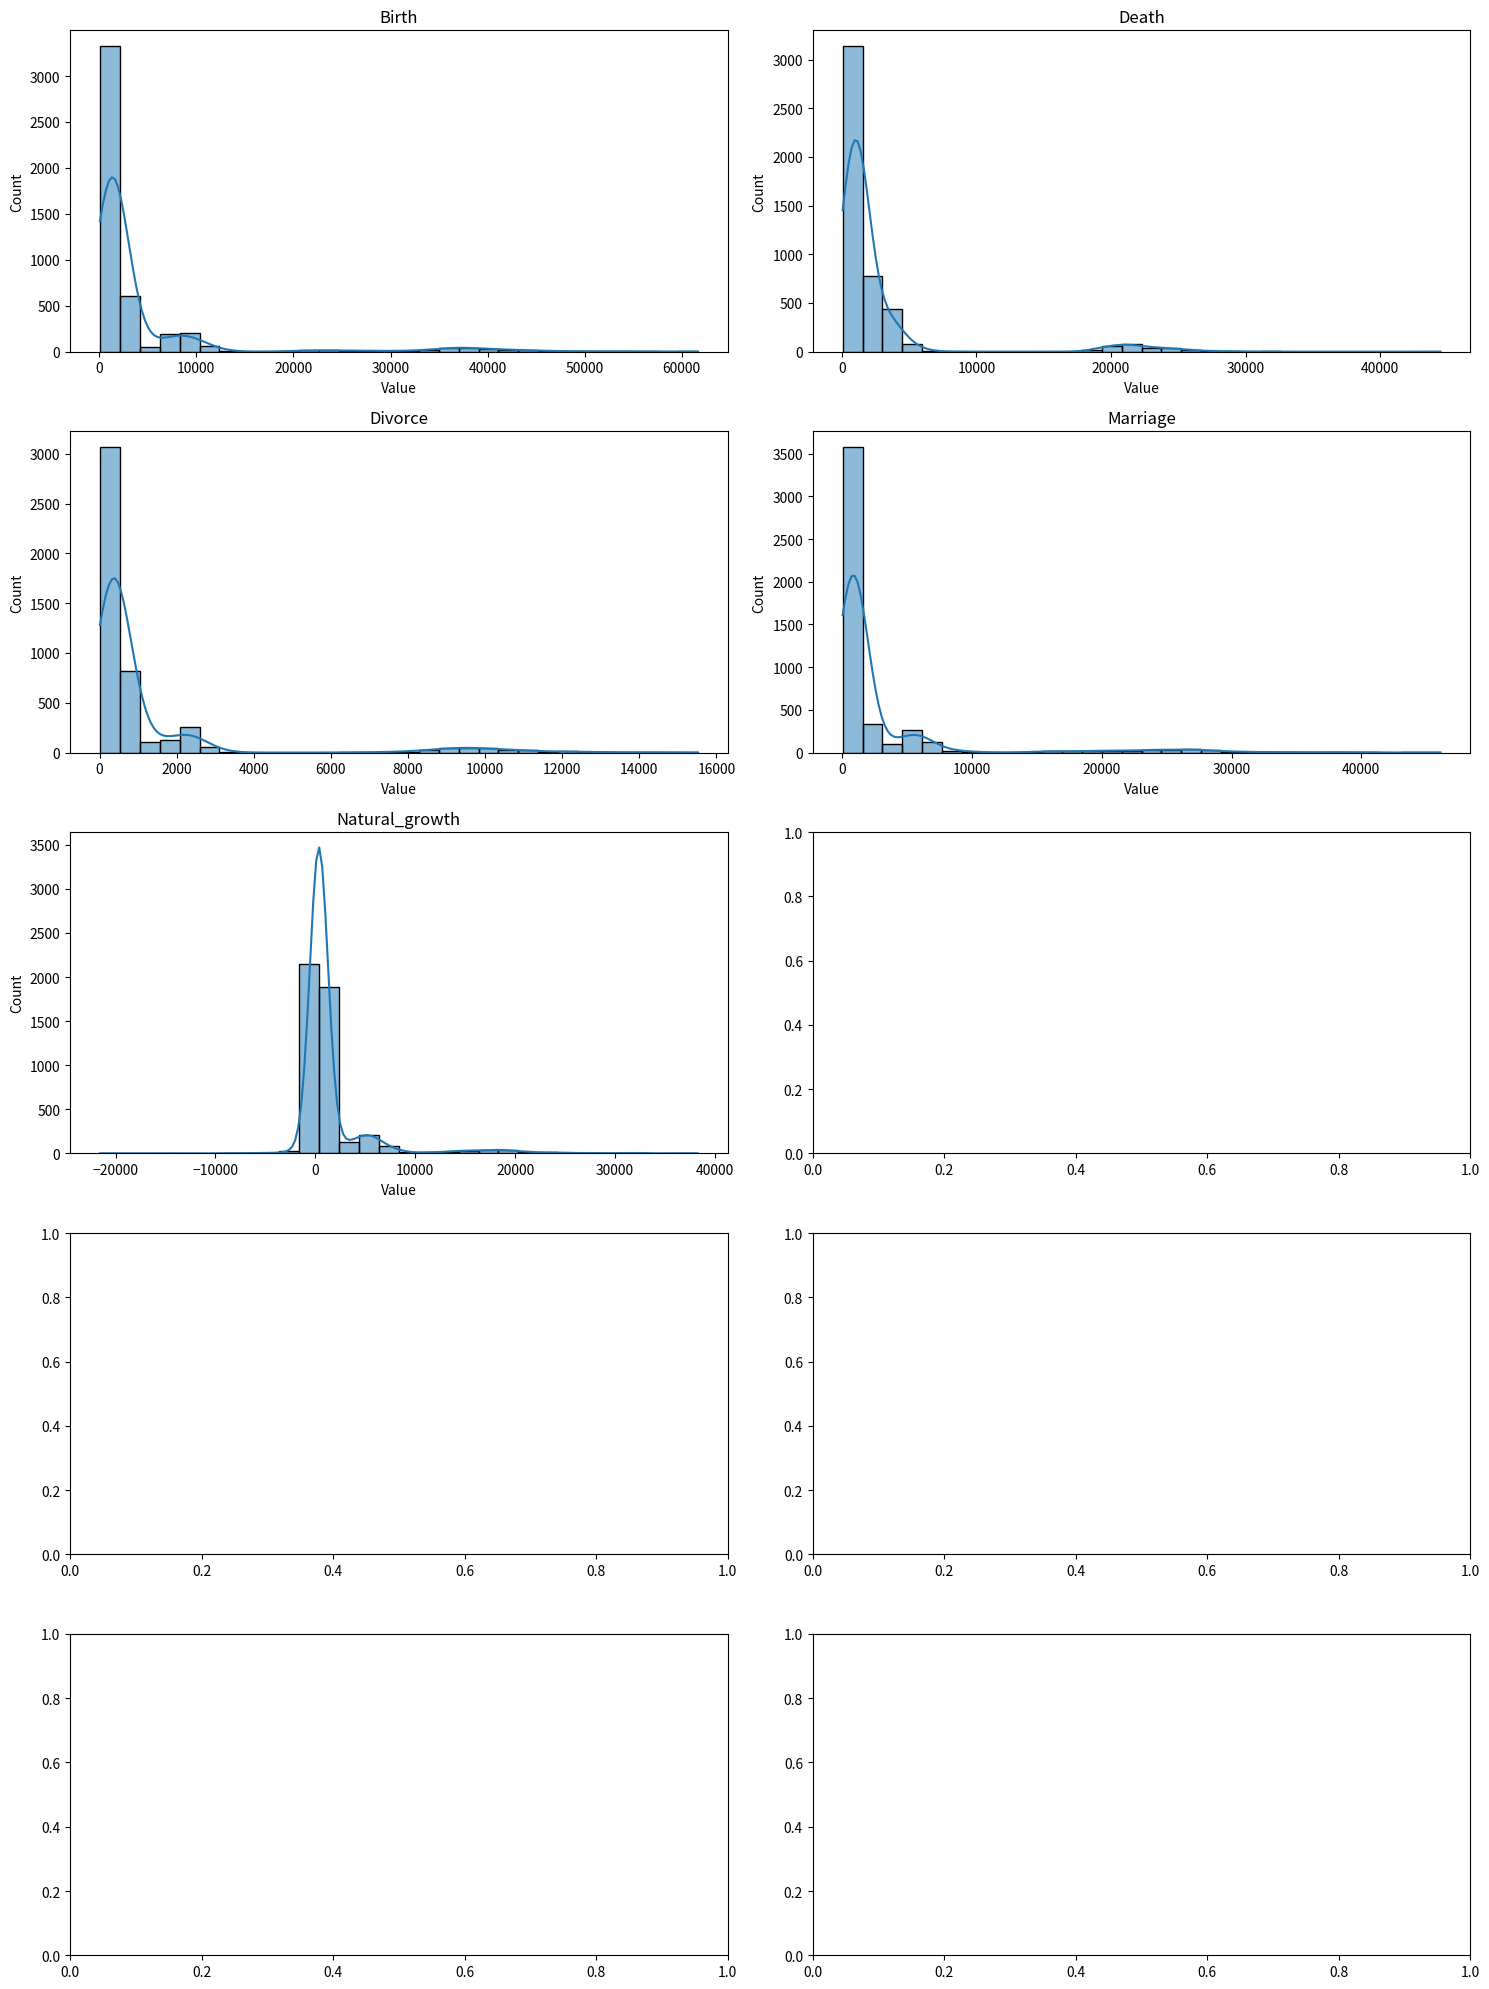

In [ ]:
#============================================================
# ▶ 개별 데이터 분포 확인 : histplot
#============================================================


# 서브플롯 설정
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten()

# 각 컬럼에 대해 histplot 그리기
for i, column in enumerate(numeric_col):
    sns.histplot(data=numeric_col, x=column, bins=30, ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 가설 3: 수도권의 높은 생활비가 출산 기피로 이어진다.
- 먼저 수도권과 비 수도권의 출산율을 비교해보자

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/Korean_demographics.csv', encoding='euc-kr')
df.set_index('Date', inplace=True)

region_birth = df[['Region','Birth_rate']]

capital_regions = region_birth[region_birth['Region'].isin(['Seoul', 'Gyeonggi-do', 'Incheon'])]
non_capital_df = region_birth[region_birth['Region'].isin(['Busan', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Daegu',
       'Daejeon', 'Gangwon-do', 'Gwangju',
       'Gyeongsangbuk-do', 'Gyeongsangnam-do','Jeju',
       'Jeollabuk-do', 'Jeollanam-do', 'Sejong', 'Ulsan',
       'Whole country'])]

capital_regions_mean = capital_regions.groupby('Region').mean()
capital_regions_mean.loc['mean'] = capital_regions_mean.mean()

non_capital_regions_mean = non_capital_df.groupby('Region').mean()
non_capital_regions_mean.loc['mean'] = non_capital_regions_mean.mean()

<Axes: xlabel='Region'>

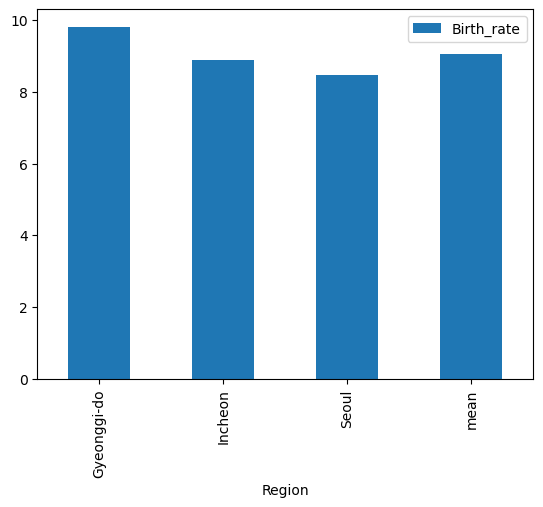

In [3]:
capital_regions_mean.plot(kind='bar')

<Axes: xlabel='Region'>

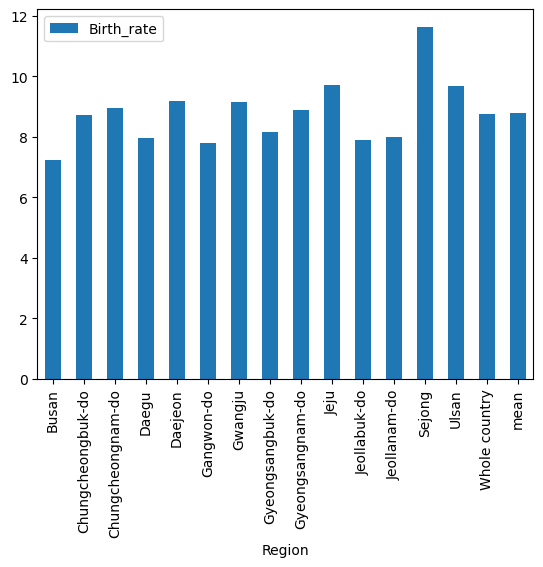

In [4]:
non_capital_regions_mean.plot(kind='bar')

- 그래프를 보면 비수도권과 수도권과 출산율을 분석해서 그래프로 나타냈다
- 그래프를 보면 수도권과 비수도권의 출산율의 평균은 딱히 차이가 나지 않는 것을 알 수 있다
- 수도권 : 9.05 , 비수도권 : 8.78

# 그럼 이제 수도권과 비수도권의 물가를 비교해보기

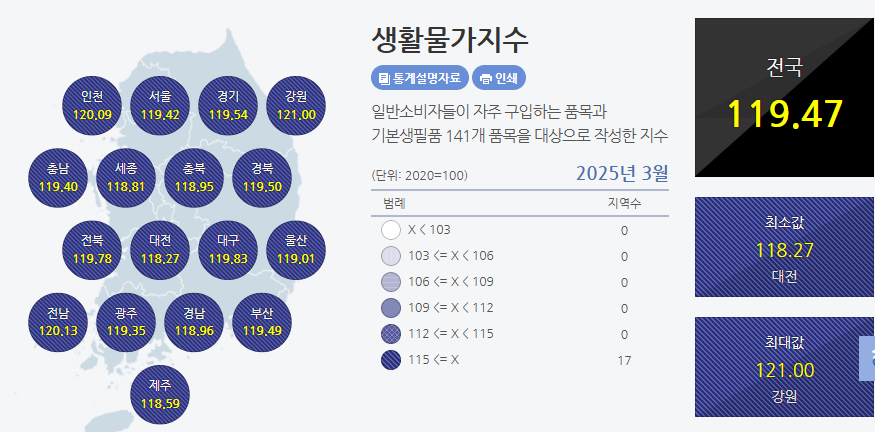

- 이 이미지는 2025년 03월 소비자 물가지수 인데 2020년을 100을 기준으로 잡았다
- 서울을 보면 119.40.이라고 써있는데 이 수치는 2020년도보다 물가가 19.4%가 상승했다는 것이다
- 그리고 평균은 119.29인데 전국적으로 별로 차이가 나지않는 것을 확인할 수 있다.
- 출처 : https://kosis.kr/regionState/statePriceLiving.do

# 결론
- 수도권과 비수도권을 비교했을 때 출산율은 별로 차이가 없는 것을 확인
- 각 지역별 물가지수도 전체적으로 별로 차이없는 것을 확인
- 가설3 : 수도권의 높은 생활비가 출산 기피로 이어진다. 이것은 의미없는 가설임을 알 수 있음